
In this challange, you are going to find a solutotion for a wheat company. 
The wheat company sells two types of thing:
- specialty wheat with kilogram
- Other things

You should make a decision tree to predict the purchase of the loyal customers:
The collected data includes  customers':
- age
- gender 
- salary 
- whether they have bought at least one wheat product online
- their distance from the store  (standardized to a number between 0 and 11) 
- how much they spent on wheat products on the week of the survey 
- how much they spent on wheat products in the month preeding the survey
- the number of  shipments each customer has ordered over the preceding year. 

You also asked each customer participating in the survey whether they would buy the wheat, and some (but not all) of the customers gave responses to that question. 

You sit back and think: if more than 70% of the interviewed customers are likely to buy wheat, you will strike the deal with the wheat farmers and sell the wheat. Otherwise, you won't strike the deal. There's some doubt in your mind about whether 70% is a reasonable threshold, but it'll do for the moment. 

To solve the problem, then, you will build a decision tree to implement a classification solution. 


-------------------------------
    

# 1. Sourcing and loading
## 1a. Import Packages

In [ ]:
import pandas as pd 
import numpy as np 
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO  
from IPython.display import Image  
import pydotplus

## 1b. Load data 

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Data/WheatCustomerDataSet.csv"
wheatData = pd.read_csv(path)

## 1c. Explore the data

In [ ]:
wheatData.head()

,Age,Gender,num_Bags_per_year,spent_week,spent_month,SlrAY,Distance,Online,Decision
0,36,Female,0,24,73,42789,0.003168,0,1.0
1,24,Male,0,44,164,74035,0.520906,0,NaN
2,24,Male,0,39,119,30563,0.916005,1,1.0
3,20,Male,0,30,107,13166,0.932098,1,NaN
4,24,Female,0,20,36,14244,0.965881,0,1.0


In [ ]:
wheatData.shape

(702, 9)

In [ ]:
wheatData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                702 non-null    int64  
 1   Gender             702 non-null    object 
 2   num_Bags_per_year  702 non-null    int64  
 3   spent_week         702 non-null    int64  
 4   spent_month        702 non-null    int64  
 5   SlrAY              702 non-null    int64  
 6   Distance           702 non-null    float64
 7   Online             702 non-null    int64  
 8   Decision           474 non-null    float64
dtypes: float64(2), int64(6), object(1)
memory usage: 49.5+ KB


In [ ]:
wheatData.describe()

,Age,num_Bags_per_year,spent_week,spent_month,SlrAY,Distance,Online,Decision
count,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,474.000000
mean,34.243590,2.710826,32.853276,107.923077,43819.843305,4.559186,0.531339,0.639241
std,13.927945,1.593629,15.731878,55.348485,26192.626943,3.116275,0.499373,0.480728
min,16.000000,0.000000,0.000000,0.000000,1617.000000,0.003168,0.000000,0.000000
25%,23.000000,1.000000,24.250000,62.000000,22812.250000,1.877812,0.000000,0.000000
50%,28.000000,3.000000,36.000000,113.500000,41975.000000,4.196167,1.000000,1.000000
75%,46.000000,4.000000,43.000000,150.750000,60223.000000,6.712022,1.000000,1.000000
max,90.000000,5.000000,62.000000,210.000000,182058.000000,10.986203,1.000000,1.000000


# 2. Cleaning, transforming and visualizing
## 2a. Cleaning the data

In [ ]:
wheatData.columns

Index(['Age', 'Gender', 'num_Bags_per_year', 'spent_week', 'spent_month',
       'SlrAY', 'Distance', 'Online', 'Decision'],
      dtype='object')

In [ ]:
wheatData = wheatData.rename(columns = {'spent_week' : 'spent_last_week', 'spent_month' : 'spent_last_month', 'SlrAY' : 'salary'})

In [ ]:
wheatData.columns 

Index(['Age', 'Gender', 'num_Bags_per_year', 'spent_last_week',
       'spent_last_month', 'salary', 'Distance', 'Online', 'Decision'],
      dtype='object')

In [ ]:
wheatData['Gender']

0      Female
1        Male
2        Male
3        Male
4      Female
        ...  
697    Female
698      Male
699      Male
700    Female
701      Male
Name: Gender, Length: 702, dtype: object

In [ ]:
wheatData['Gender'].unique()

array(['Female', 'Male', 'female', 'F', 'f ', 'FEMALE', 'MALE', 'male',
       'M'], dtype=object)

In [ ]:
wheatData = wheatData.replace({'Gender' : {'female' : 'Female' , 'f ' : 'Female' , 'F' : 'Female' , 'FEMALE' : 'Female'}})

In [ ]:
wheatData['Gender'].unique()

array(['Female', 'Male', 'MALE', 'male', 'M'], dtype=object)

In [ ]:
wheatData = wheatData.replace({'Gender' : {'MALE' : 'Male' , 'male' : 'Male' , 'M' : 'Male'}})

In [ ]:
wheatData['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [ ]:
wheatData['Decision'].unique()

array([ 1., nan,  0.])

In [ ]:
wheatData = wheatData.replace({'Decision' : {1.0 : 'YES' , 0.0 : 'NO'}})

In [ ]:
wheatData['Decision'].unique()

array(['YES', nan, 'NO'], dtype=object)

## 2b. Train/test split

In [ ]:
NOPrediction = wheatData.dropna()
NOPrediction['Decision'].describe()

count     474
unique      2
top       YES
freq      303
Name: Decision, dtype: object

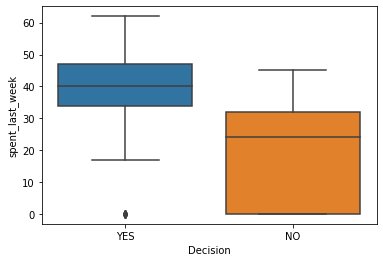

In [ ]:
sns.boxplot(data = NOPrediction, x = 'Decision', y = 'spent_last_week')

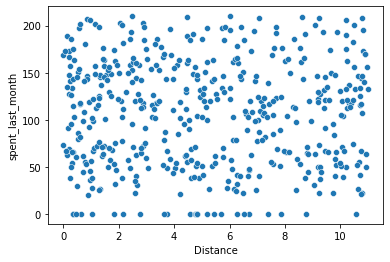

In [ ]:
sns.scatterplot(data = NOPrediction, x = 'Distance', y = 'spent_last_month')

In [ ]:
Prediction = NOPrediction['Decision'].dropna()

In [ ]:
Prediction.describe()

count     474
unique      2
top       YES
freq      303
Name: Decision, dtype: object

In [ ]:
NOPrediction.columns

Index(['Age', 'Gender', 'num_Bags_per_year', 'spent_last_week',
       'spent_last_month', 'salary', 'Distance', 'Online', 'Decision'],
      dtype='object')

In [ ]:
features = ['Age' , 'Gender' , 'num_Bags_per_year' , 'spent_last_week' , 'spent_last_month' , 'salary' , 'Distance' , 'Online']

X = NOPrediction[features]

y = NOPrediction.Decision

In [ ]:
X = pd.get_dummies(X, columns = ['Gender'])
X.head(15)

,Age,num_Bags_per_year,spent_last_week,spent_last_month,salary,Distance,Online,Gender_Female,Gender_Male
0,36,0,24,73,42789,0.003168,0,1,0
2,24,0,39,119,30563,0.916005,1,0,1
4,24,0,20,36,14244,0.965881,0,1,0
5,20,0,23,28,14293,1.036346,1,1,0
6,34,0,55,202,91035,1.134851,0,1,0
8,27,0,49,145,43716,1.327208,0,0,1
9,16,0,55,176,4701,1.445575,1,1,0
10,25,0,37,148,47993,1.556569,0,1,0
14,32,0,42,158,51563,2.414472,1,0,1
15,20,0,0,63,13649,2.634045,1,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=246, train_size = .75)

# 3. Modelling

## Model 1: Entropy model - no max_depth

In [ ]:
entr_model = tree.DecisionTreeClassifier(criterion = 'entropy')

entr_model = entr_model.fit(X_train, y_train)

y_pred = entr_model.predict(X_test)

pd.Series(y_pred)

entr_model

DecisionTreeClassifier(criterion='entropy')

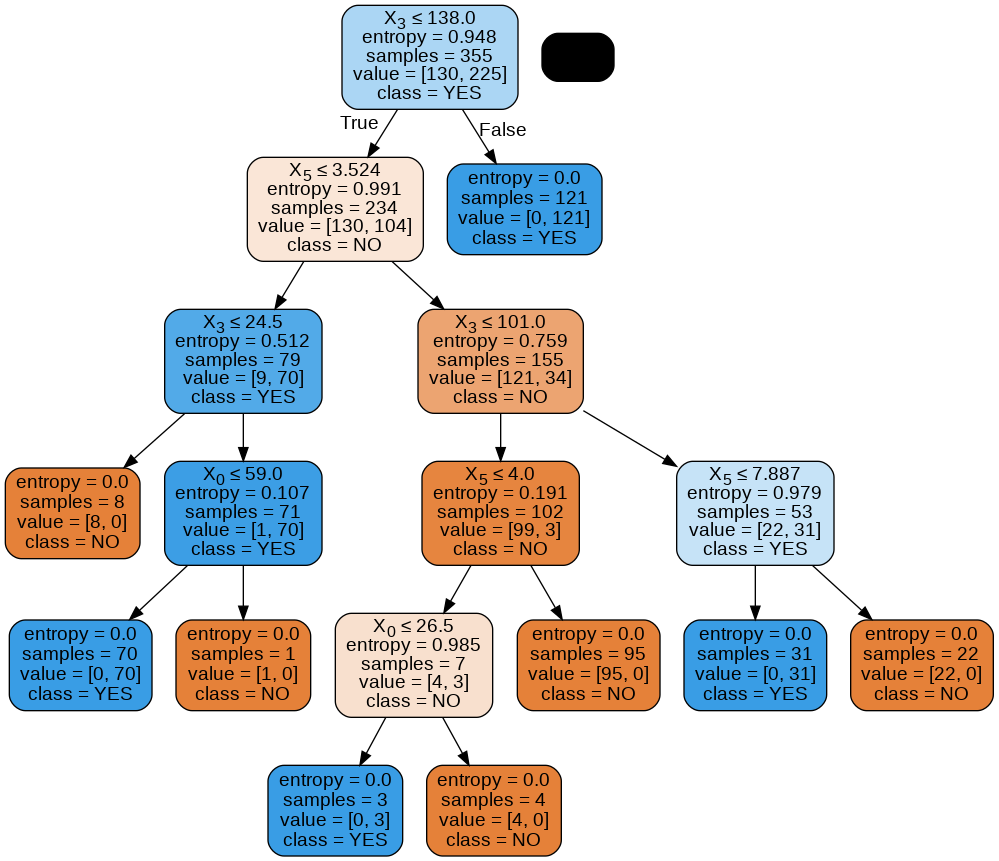

In [ ]:
from sklearn.tree import export_graphviz
dot_data = StringIO()

export_graphviz(entr_model, out_file=dot_data, filled=True, rounded=True, special_characters=True, class_names=entr_model.classes_)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('entr.png')
Image(graph.create_png())

## Model 1: Entropy model - no max_depth: Interpretation and evaluation

In [ ]:
print("Model Entropy - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = "YES"))
print('Precision score for "No"' , metrics.precision_score(y_test,y_pred, pos_label = "NO"))
print('Recall score for "Yes"' , metrics.recall_score(y_test,y_pred, pos_label = "YES"))
print('Recall score for "No"' , metrics.recall_score(y_test,y_pred, pos_label = "NO"))

Model Entropy - no max depth
Accuracy: 0.9915966386554622
Balanced accuracy: 0.9878048780487805
Precision score for "Yes" 0.9873417721518988
Precision score for "No" 1.0
Recall score for "Yes" 1.0
Recall score for "No" 0.975609756097561


## Model 2: Gini impurity model - no max_depth

In [ ]:
gini_model = tree.DecisionTreeClassifier(criterion = 'gini')

gini_model = gini_model.fit(X_train, y_train)

y_pred = gini_model.predict(X_test)

pd.Series(y_pred)

gini_model

DecisionTreeClassifier()

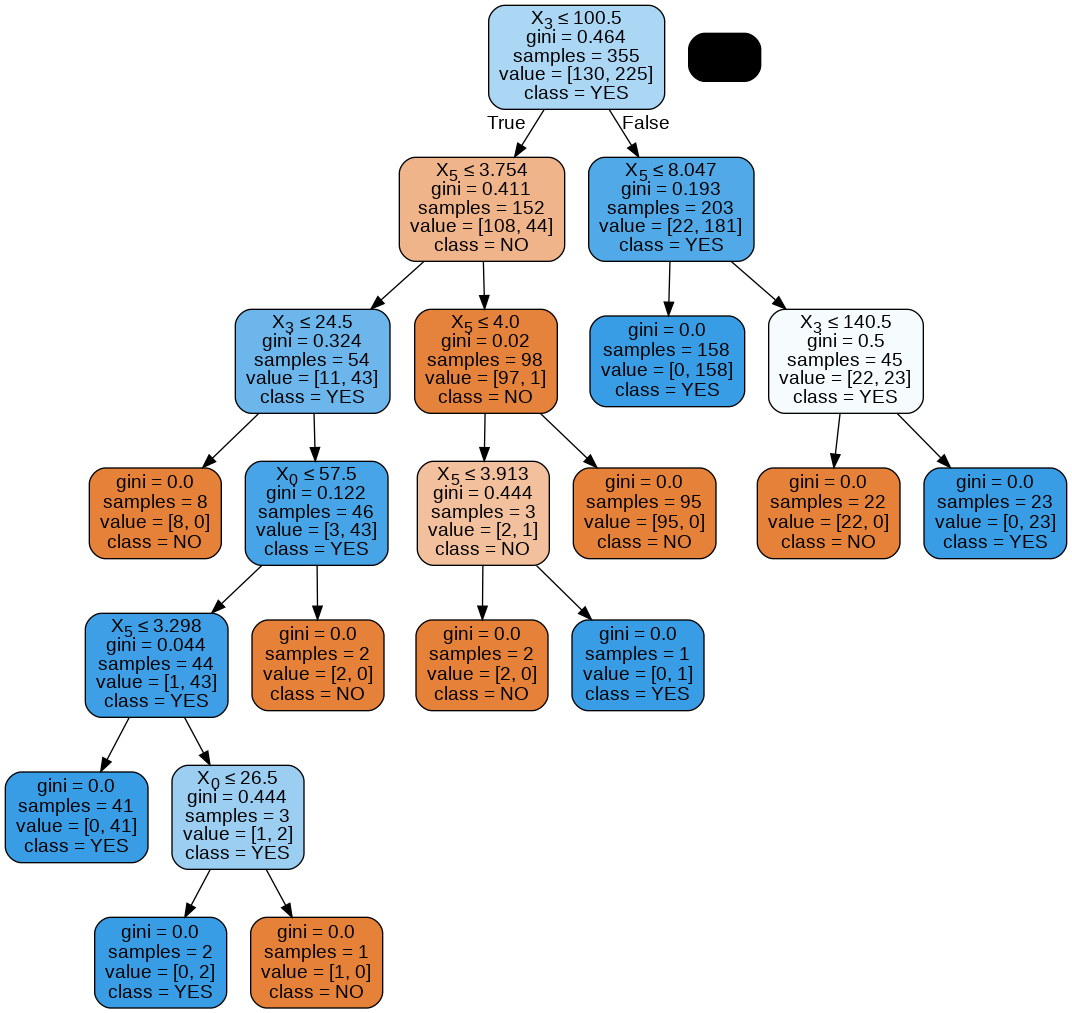

In [ ]:
dot_data = StringIO()
export_graphviz(gini_model, out_file=dot_data, filled=True, rounded=True, special_characters=True, class_names=gini_model.classes_) 

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('gini.png')
Image(graph.create_png())

In [ ]:
print("Model Gini impurity model")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = "YES"))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = "NO"))

Model Gini impurity model
Accuracy: 0.9831932773109243
Balanced accuracy: 0.9813946216385241
Precision score 0.9871794871794872
Recall score 0.975609756097561


## Model 3: Entropy model - max depth 3

In [ ]:
entr_model2 = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)

entr_model2 = entr_model2.fit(X_train, y_train)

y_pred = entr_model2.predict(X_test)

pd.Series(y_pred)

entr_model2

DecisionTreeClassifier(criterion='entropy', max_depth=3)

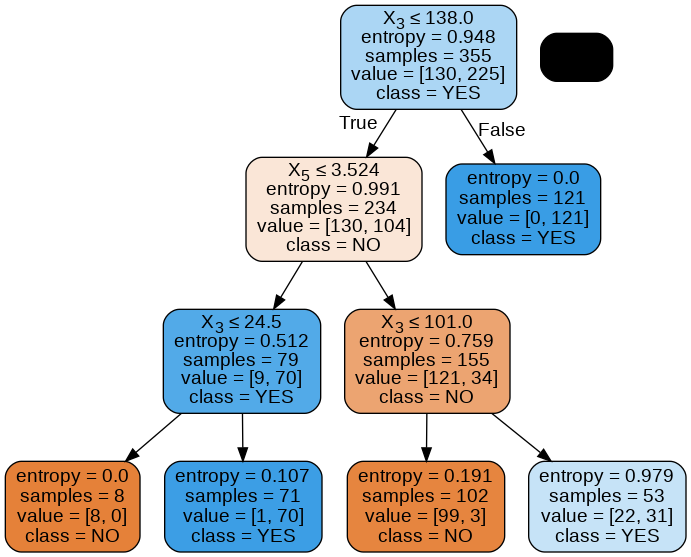

In [ ]:
dot_data = StringIO()
export_graphviz(entr_model2, out_file=dot_data, filled=True, rounded=True, special_characters=True, class_names=entr_model2.classes_) 

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('entr2.png')
Image(graph.create_png()) 

In [ ]:
print("Model Entropy model max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_pred, pos_label = "YES"))
print('Recall score for "No"' , metrics.recall_score(y_test,y_pred, pos_label = "NO"))

Model Entropy model max depth 3
Accuracy: 0.907563025210084
Balanced accuracy: 0.8658536585365854
Precision score for "Yes" 0.8764044943820225
Recall score for "No" 0.7317073170731707


## Model 4: Gini impurity  model - max depth 3

In [ ]:
gini_model2 = tree.DecisionTreeClassifier(criterion = 'gini', random_state = 1234, max_depth  = 3 )

gini_model2 = gini_model2.fit(X_train, y_train)

y_pred = gini_model2.predict(X_test)

pd.Series(y_pred)

gini_model2

DecisionTreeClassifier(max_depth=3, random_state=1234)

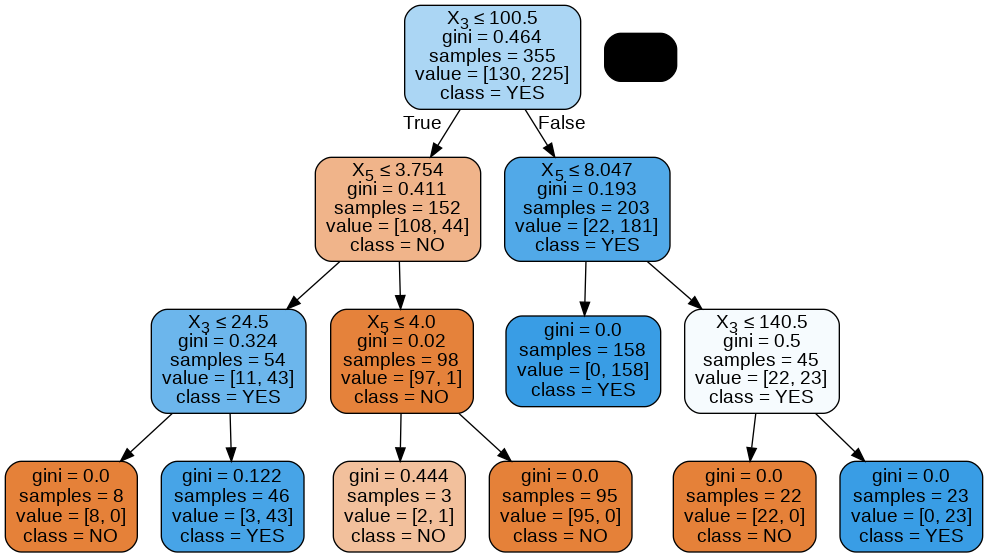

In [ ]:
dot_data = StringIO()
export_graphviz(gini_model2, out_file=dot_data, filled=True, rounded=True, special_characters=True, class_names=gini_model2.classes_) 

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('gini2.png')
Image(graph.create_png())

In [ ]:
print("Gini impurity  model - max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = "YES"))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = "NO"))

Gini impurity  model - max depth 3
Accuracy: 0.9747899159663865
Balanced accuracy: 0.9691994996873046
Precision score 0.9746835443037974
Recall score 0.9512195121951219


# 4. Evaluating and concluding
## 4a. How many customers will buy new Wheat Product? 
Let's first ascertain how many loyal customers claimed, in the survey, that they will purchase the product. 

In [ ]:
wheatData['Decision'].value_counts()

YES    303
NO     171
Name: Decision, dtype: int64

In [ ]:
feature_cols = ['Age' , 'Gender' , 'num_Bags_per_year' , 'spent_last_week' , 'spent_last_month' , 'salary' , 'Distance' , 'Online']

new_X = NOPrediction[feature_cols]

In [ ]:
new_X = pd.get_dummies(new_X)

potential_buyers = gini_model2.predict(new_X)

In [ ]:
np.unique(potential_buyers, return_counts=True)

(array(['NO', 'YES'], dtype=object), array([168, 306]))

In [ ]:
len(wheatData.index)

702

In [ ]:
np.count_nonzero(potential_buyers == 'YES')/np.count_nonzero(potential_buyers)

0.6455696202531646

In [ ]:
percentage = str(int(np.count_nonzero(potential_buyers == 'YES')/np.count_nonzero(potential_buyers) * 100)) + '%'
print(percentage)

64%


## 4b. Decision
Remember how you thought at the start: if more than 70% of the interviewed customers are likely to buy the new wheat product, you will strike the deal with the farm. Otherwise, you won't strike the deal
Now according to your decision tree write you will make new product or not?

#No. Because 64% of the customers are likely to buy the new product which is lower than 70%.